In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils.parse_pars import parse_pars
from spamm.run_spamm import spamm
import run_fe, run_nc, run_bc, run_hg, run_ne
from utils.add_in_quadrature import add_in_quadrature
from spamm.analysis import plot_best_models
from spamm.Samples import Samples

In [2]:
# This should be a wllength range from 1000-10,000A, every 0.5A
TEST_wl = parse_pars()["testing"]

# Create wllength array from min, max and step values
wl = np.arange(TEST_wl["wl_min"], TEST_wl["wl_max"], TEST_wl["wl_step"])

# These values were picked by hand to provide the most realistic power law.
NC_PARAMS = {"wl": wl,
             "slope1": 2.3,
             "norm_PL": 5e-15,
             "broken_pl": False}

# The normalizations are drawn from a gaussian sample with mu=9.06e-15,
# sigma=3.08946e-15 (from 0->template max flux). fe_width is halfway 
# between range in parameters. wl is very close to template span (1075-7535)
FE_PARAMS = {"fe_norm_1": 1.07988504e-14,
             "fe_norm_2": 6.91877436e-15,
             "fe_norm_3": 5e-15,# 8.68930476e-15, 
             "fe_width": 5450,
             "no_templates": 3,
             "wl": wl}

# These values are just the midpoints of the parameter space in parameters.yaml
BC_PARAMS = {"bc_norm": 3e-14,
             "bc_tauBE": 1.,
             "bc_logNe": 5.5,
             "bc_loffset": 0.,
             "bc_lwidth": 5050.,
             "bc_Te": 50250.,
             "bc_lines": 201.5,
             "wl": wl}

# These values are just the midpoints of the parameter space in parameters.yaml
HG_PARAMS = {"hg_norm_1": 6e-15,
             "hg_stellar_disp": 515,
             "no_templates": 1,
             "wl": wl}

NEL_PARAMS = {"width": 10, 
              "amp_1": 5e-14, 
              "center_1": 4830,
              "amp_2": 8e-14, 
              "center_2": 6800,
              "amp_3": 15e-14, 
              "center_3": 3000,
              "wl": wl}

LINEOUT = "#"*75

In [3]:
def generate_data(components=None, comp_params=None):
    
    all_wls = []
    all_fluxes = []
    all_errs = []
    comb_p = {}
    comp_names = {}
    
    for component in components:
        component = component.upper()
        if component == "PL" or component == "NC":
            comp_wl, comp_flux, comp_err, comp_p = run_nc.create_nc(comp_params["PL"])
            comp_names["PL"] = True
            
        elif component == "FE":
            comp_wl, comp_flux, comp_err, comp_p = run_fe.create_fe(comp_params["FE"])
            comp_names["FE"] = True
            
        elif component == "BC" or component == "BPC":
            comp_wl, comp_flux, comp_err, comp_p = run_bc.create_bc(comp_params["BC"])
            comp_names["BC"] = True
            comp_names["BpC"] = True
            
        elif component == "HG" or component == "HOST":
            comp_wl, comp_flux, comp_err, comp_p = run_hg.create_hg(comp_params["HOST"])
            comp_names["HOST"] = True

        elif component == "NEL":
            comp_wl, comp_flux, comp_err, comp_p = run_ne.create_ne(comp_params["NEL"])
            comp_names["NEL"] = True
            
        all_fluxes.append(comp_flux)
        all_wls.append(comp_wl)
        all_errs.append(comp_err)
        comb_p = {**comb_p, **comp_p}

    comb_wl = wl
    comb_flux = np.sum(all_fluxes, axis=0)
    comb_err = add_in_quadrature(all_errs)
    
    print(f"{LINEOUT}\nUsing components: {components}")
    
    return comb_wl, comb_flux, comb_err, all_fluxes, comp_names

NC params: {'wl': array([1000. , 1000.5, 1001. , ..., 9998.5, 9999. , 9999.5]), 'slope1': 2.3, 'norm_PL': 5e-15, 'broken_pl': False}
HG params: {'hg_norm_1': 6e-15, 'hg_stellar_disp': 515, 'no_templates': 1, 'wl': array([1000. , 1000.5, 1001. , ..., 9998.5, 9999. , 9999.5])}
comp_params: [6e-15, 515]
BC params: {'bc_norm': 3e-14, 'bc_tauBE': 1.0, 'bc_logNe': 5.5, 'bc_loffset': 0.0, 'bc_lwidth': 5050.0, 'bc_Te': 50250.0, 'bc_lines': 201.5, 'wl': array([1000. , 1000.5, 1001. , ..., 9998.5, 9999. , 9999.5])}
Fe params: {'fe_norm_1': 1.07988504e-14, 'fe_norm_2': 6.91877436e-15, 'fe_norm_3': 5e-15, 'fe_width': 5450, 'no_templates': 3, 'wl': array([1000. , 1000.5, 1001. , ..., 9998.5, 9999. , 9999.5])}
###########################################################################
Using components: ['PL', 'HG', 'BC', 'FE']


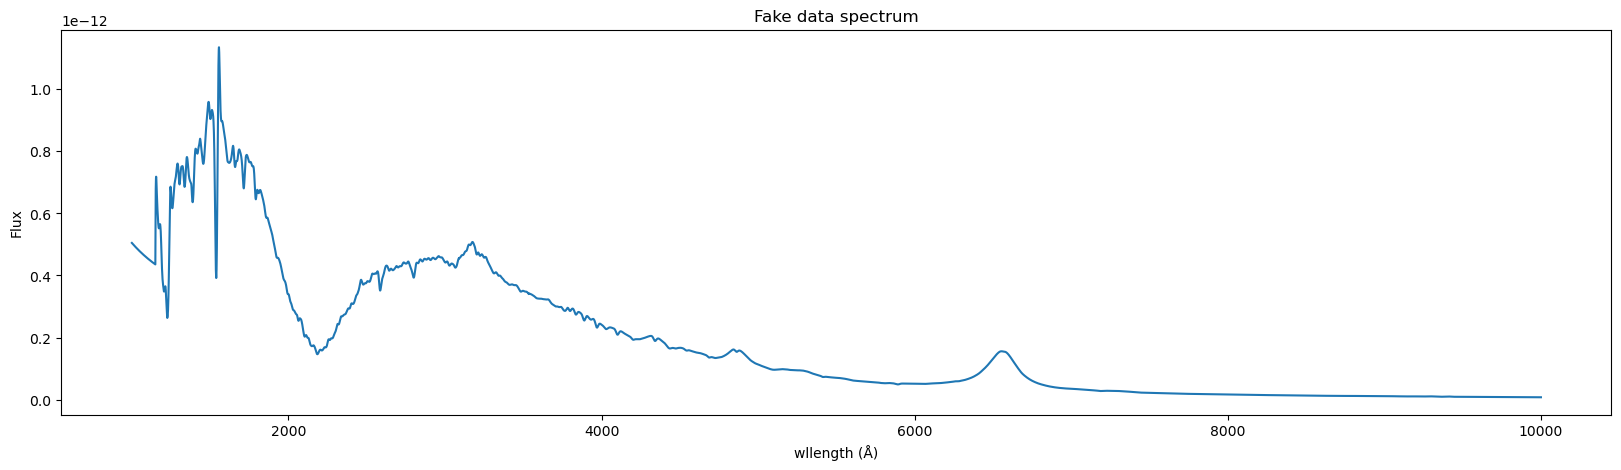

In [4]:
components=["PL", "HG", "BC", "FE"]
comp_params={"PL": NC_PARAMS, "HOST": HG_PARAMS, "BC": BC_PARAMS, "FE": FE_PARAMS}

wl, flux, flux_err, all_fluxes, comp_names = generate_data(components=components, comp_params=comp_params)

fig = plt.figure(figsize=(20,5))
plt.plot(wl, flux)
plt.title(f"Fake data spectrum")
plt.xlabel("wllength (Å)")
plt.ylabel("Flux");

In [ ]:
spamm(comp_names, (wl, flux, flux_err), comp_params=comp_params, n_walkers=64, n_iterations=300, 
      outdir="combined_example", picklefile="combined", parallel=True)

S = Samples("combined_example/combined.pickle.gz", burn=50)
plot_best_models(S)

 19%|████████                                  | 58/300 [00:33<02:27,  1.64it/s]